In [5]:
import os
import pandas as pd
import boto3

from order_book.simulation import *
from order_book.transformation import *
from order_book.loader import *
import awswrangler as wr

import ml_model
from ml_model.test_model import *
from ml_model.seq2seq import *

import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=FutureWarning)
boto3.setup_default_session(profile_name="data")

%reload_ext autoreload
%autoreload 2

In [218]:
dl = DataLoader()

start = datetime(2024, 1, 1, 20)
end = datetime(2024, 1, 1, 21)

order_data = dl.get_raw_product_orders(start, end)

### Order Distribution

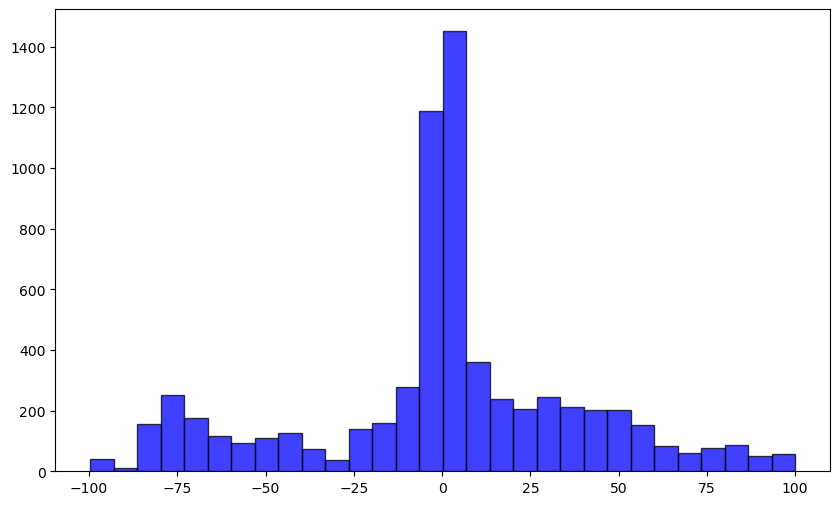

In [220]:
obs_by_ticks = get_obs_by_ticks(order_data=order_data, ticks=1000)

price_diffs = np.array([])
spreads = np.array([])

for (time, ob) in obs_by_ticks:
    price = (ob[ob["Side"] == "SELL"]["Price"].min() + ob[ob["Side"] == "BUY"]["Price"].max())/2
    spread = ob[ob["Side"] == "SELL"]["Price"].min() - ob[ob["Side"] == "BUY"]["Price"].max()

    # We ignore all orders +/- 100
    ob = ob[ob["Price"] < price + 100]
    ob = ob[ob["Price"] > price - 100]
    
    price_diff = np.array(ob["Price"] - price)

    price_diffs = np.hstack((price_diffs, price_diff))



plt.figure(figsize=(10, 6))
plt.hist(price_diffs, bins=30, alpha=0.75, color='blue', edgecolor='black')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(spreads, bins=30, alpha=0.75, color='blue', edgecolor='black')
plt.show()


In [221]:
np.std(price_diffs)

39.085373584482696

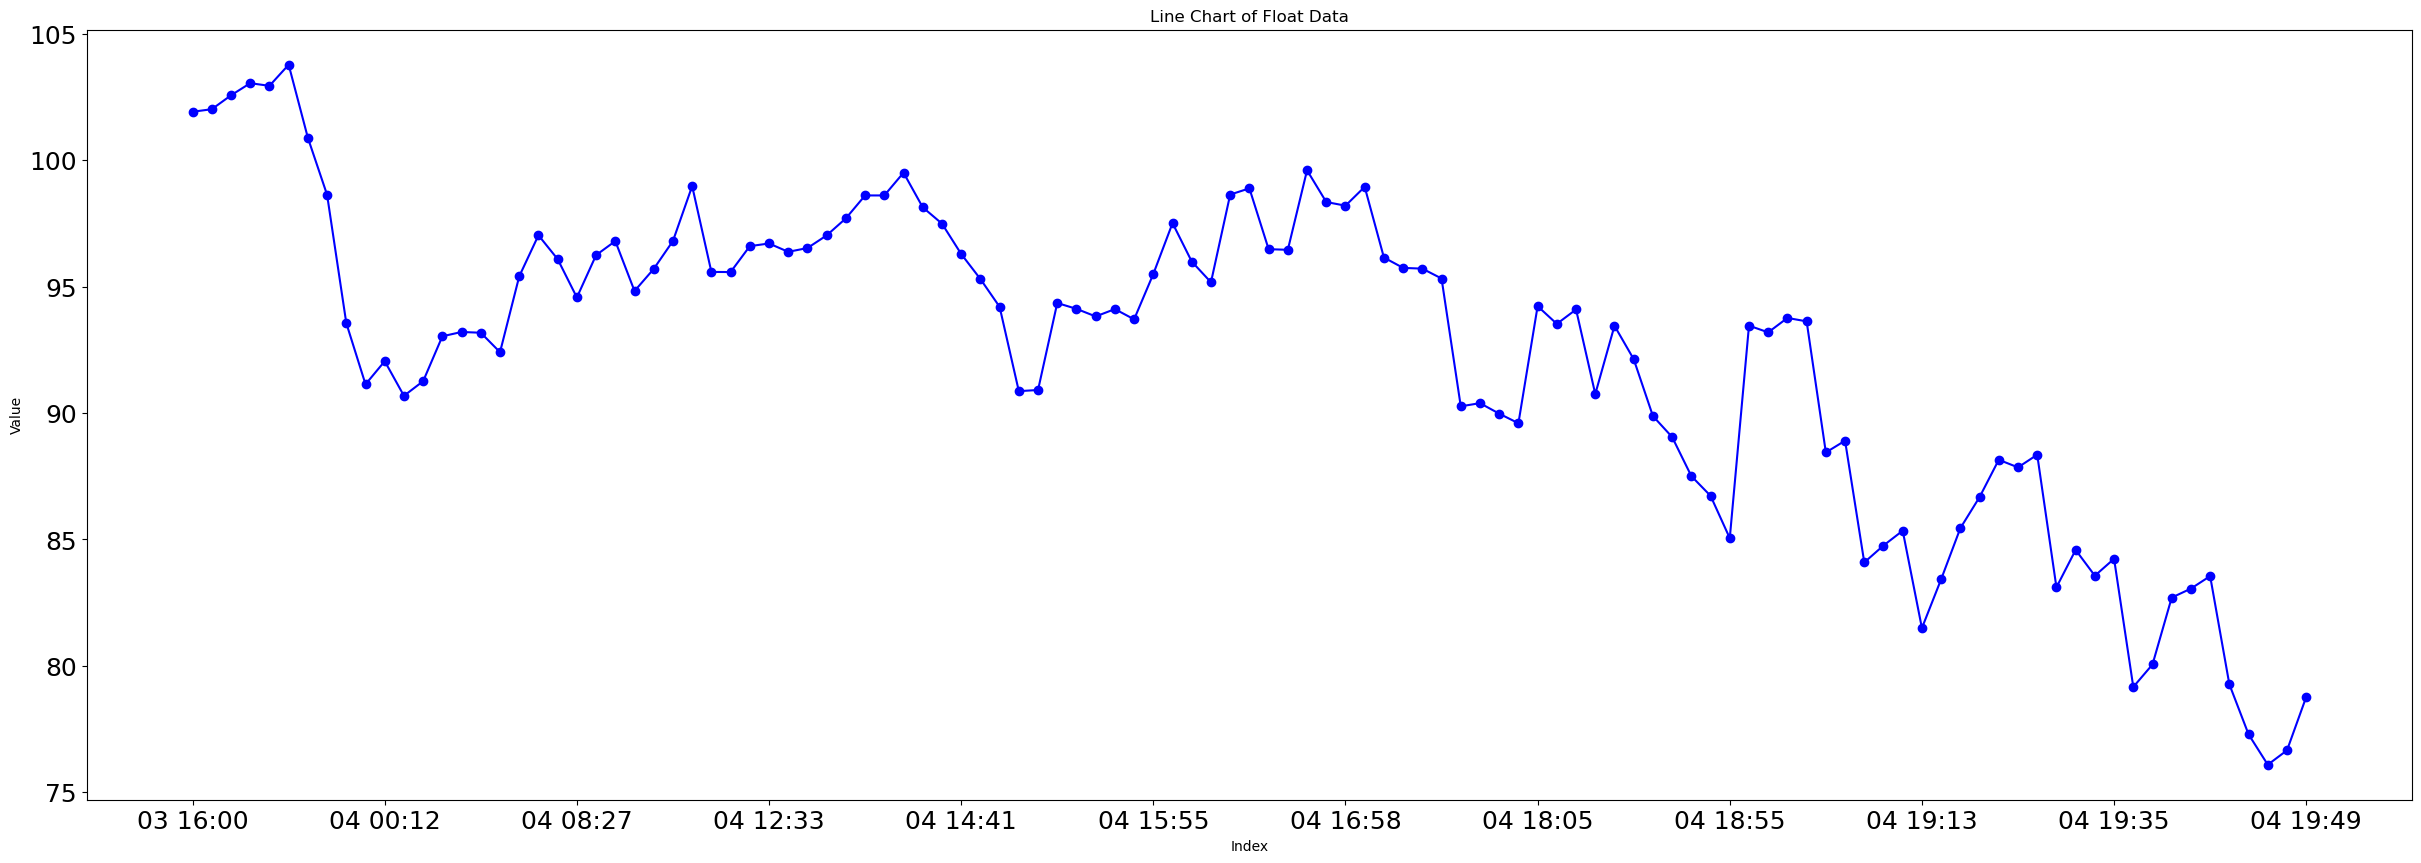

In [26]:

plt.figure(figsize=(30, 10)) 
plt.plot(price_list, marker='o', linestyle='-', color='b')


plt.xticks(ticks=range(0, len(time_list), 10), labels=[time_list[i] for i in range(0, len(time_list), 10)],fontsize=18)

plt.yticks(fontsize=18)

# Add a title
plt.title('Line Chart of Float Data')

# Add x and y labels
plt.xlabel('Index')
plt.ylabel('Value')

# Display the chart
plt.show()

In [76]:
index_data_x = None

for month in range(1,6,1):
    for day in range(1,32,1):

        df = dl.get_market_indices(2024,month,day)
        if df is not None:
            if index_data_x is None:
                index_data_x = df
            else:
                index_data_x = pd.concat([index_data_x, df], ignore_index=True)

In [151]:
index_data = index_data_x.copy()
index_data['DeliveryStart'] = index_data['DeliveryStart'].apply(lambda x: x[11:-1])

74382

### Price Analysis

In [152]:
price_data_60_ID3 = index_data[(index_data["TimeResolution"] == "60min") & (index_data["IndexName"] == "ID3")]
price_data_60_ID3 = price_data_60_ID3.groupby('DeliveryStart')['IndexPrice'].mean().reset_index()

price_data_30_ID3 = index_data[(index_data["TimeResolution"] == "30min") & (index_data["IndexName"] == "ID3")]
price_data_30_ID3 = price_data_30_ID3.groupby('DeliveryStart')['IndexPrice'].mean().reset_index()

price_data_15_ID3 = index_data[(index_data["TimeResolution"] == "15min") & (index_data["IndexName"] == "ID3")]
price_data_15_ID3 = price_data_15_ID3.groupby('DeliveryStart')['IndexPrice'].mean().reset_index()

In [153]:
# Split 60 min data
df1 = price_data_60_ID3.copy()
df1["DeliveryStart"] = df1["DeliveryStart"].apply(lambda time : (datetime.strptime(time, '%H:%M:%S') + timedelta(minutes=15)).strftime('%H:%M:%S'))

df2 = price_data_60_ID3.copy()
df2["DeliveryStart"] = df2["DeliveryStart"].apply(lambda time : (datetime.strptime(time, '%H:%M:%S') + timedelta(minutes=30)).strftime('%H:%M:%S'))

df3 = price_data_60_ID3.copy()
df3["DeliveryStart"] = df3["DeliveryStart"].apply(lambda time : (datetime.strptime(time, '%H:%M:%S') + timedelta(minutes=45)).strftime('%H:%M:%S'))

price_data_60_ID3 = pd.concat([price_data_60_ID3, df1, df2, df3], ignore_index=True)
price_data_60_ID3 = price_data_60_ID3.sort_values(by='DeliveryStart').reset_index(drop=True)

,DeliveryStart,IndexPrice
0,00:00:00,58.352109
1,00:15:00,58.352109
2,00:30:00,58.352109
3,00:45:00,58.352109
4,01:00:00,56.761156
...,...,...
91,22:45:00,64.657687
92,23:00:00,60.594286
93,23:15:00,60.594286
94,23:30:00,60.594286


In [154]:
# Split 30 min data
df1 = price_data_30_ID3.copy()
df1["DeliveryStart"] = df1["DeliveryStart"].apply(lambda time : (datetime.strptime(time, '%H:%M:%S') + timedelta(minutes=15)).strftime('%H:%M:%S'))

price_data_30_ID3 = pd.concat([price_data_30_ID3, df1], ignore_index=True)
price_data_30_ID3 = price_data_30_ID3.sort_values(by='DeliveryStart').reset_index(drop=True)
price_data_30_ID3

,DeliveryStart,IndexPrice
0,00:00:00,60.798299
1,00:15:00,60.798299
2,00:30:00,55.495578
3,00:45:00,55.495578
4,01:00:00,57.621837
...,...,...
91,22:45:00,59.619932
92,23:00:00,66.757619
93,23:15:00,66.757619
94,23:30:00,55.047687


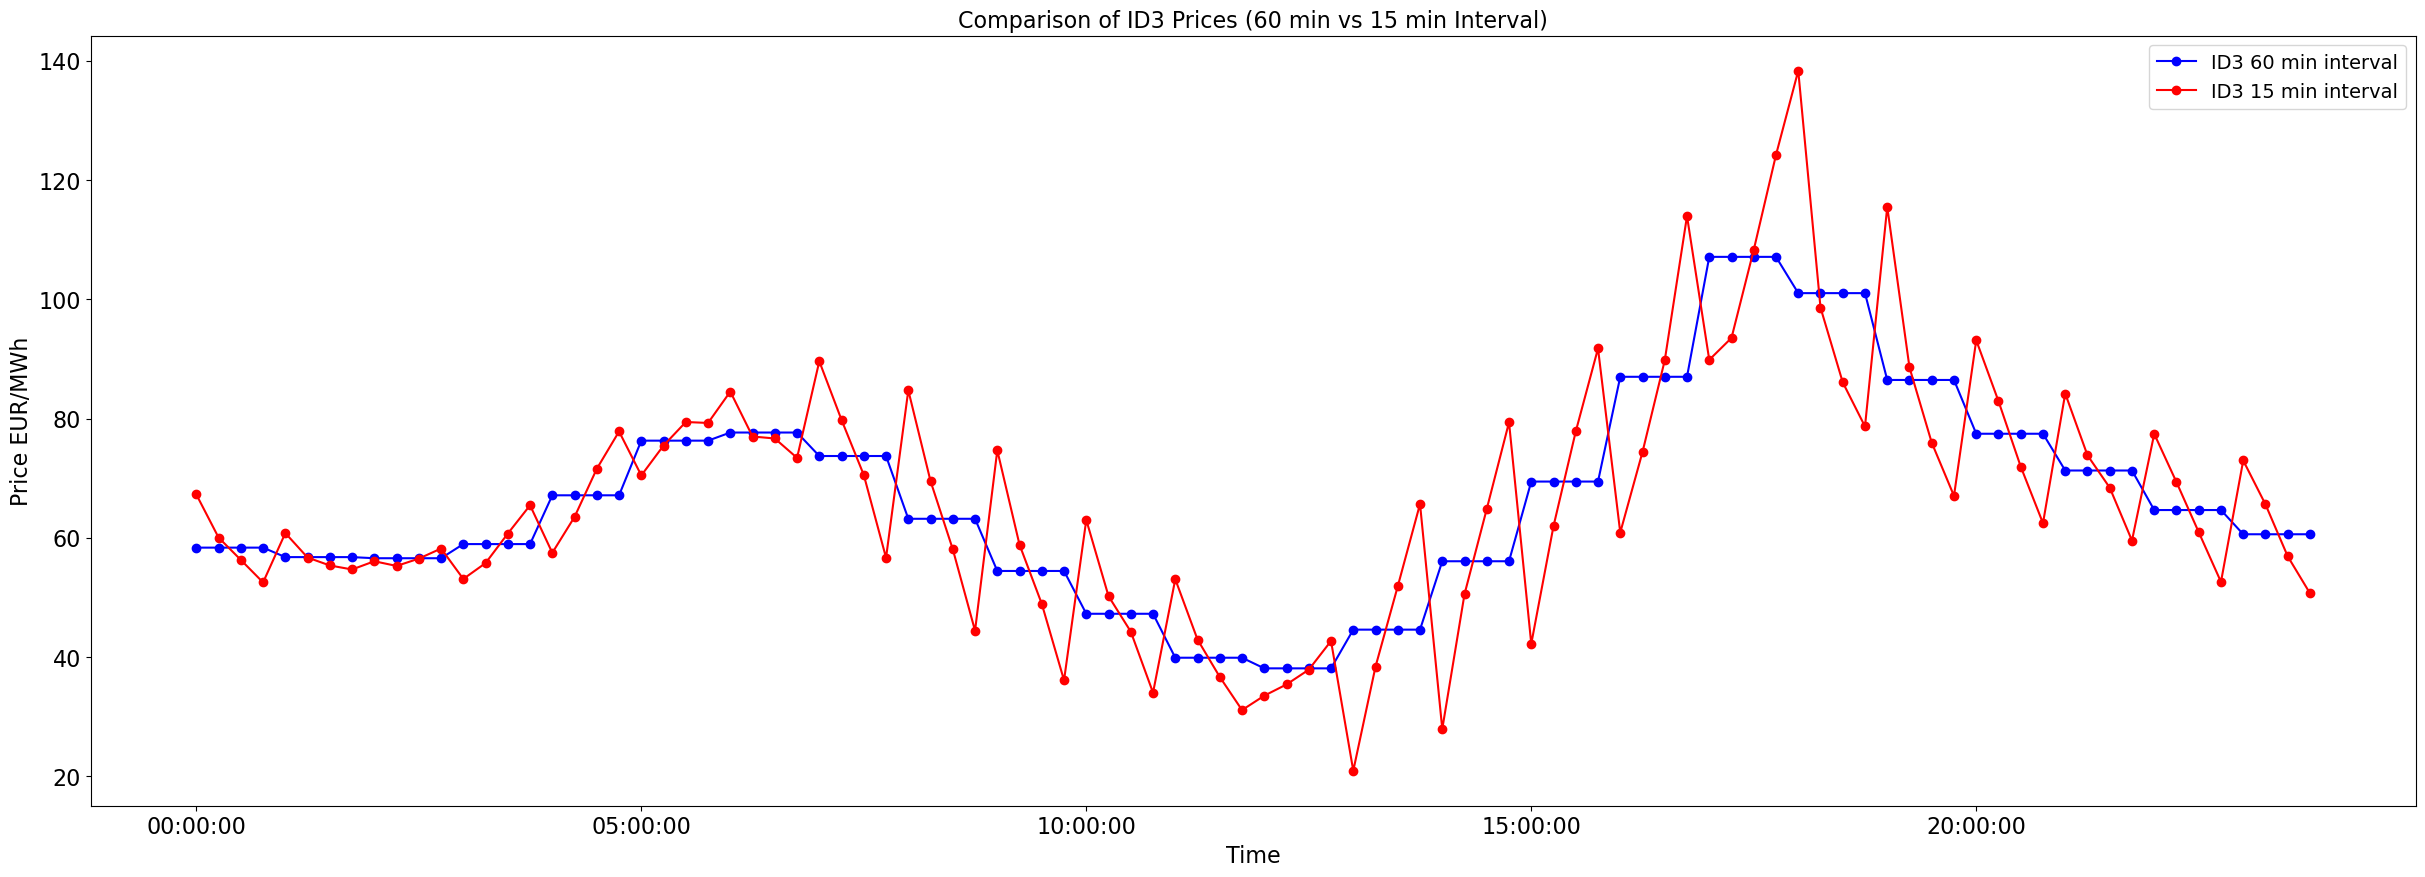

In [170]:
plt.figure(figsize=(30, 10))
plt.plot(price_data_60_ID3["IndexPrice"], marker='o', linestyle='-', color='b', label='ID3 60 min interval')
plt.plot(price_data_15_ID3["IndexPrice"], marker='o', linestyle='-', color='r', label='ID3 15 min interval')
plt.yticks(fontsize=16)


x_labels = price_data_15_ID3["DeliveryStart"]
plt.xticks(ticks=range(0, len(x_labels), 20), labels=[x_labels[i] for i in range(0, len(x_labels), 20)], fontsize=16)



# Add a title
plt.title('Comparison of ID3 Prices (60 min vs 15 min Interval)', fontsize=16)



# Add x and y labels
plt.xlabel('Time', fontsize=16)
plt.ylabel('Price EUR/MWh', fontsize=16)

plt.legend(fontsize=14)

# Display the chart
plt.show()

### Volume Analysis

In [195]:
volume_data_60_IDF = index_data[(index_data["TimeResolution"] == "60min") & (index_data["IndexName"] == "IDFULL")]
volume_data_60_IDF = volume_data_60_IDF.groupby('DeliveryStart')['IndexVolume'].mean().reset_index()

volume_data_30_IDF = index_data[(index_data["TimeResolution"] == "30min") & (index_data["IndexName"] == "IDFULL")]
volume_data_30_IDF = volume_data_30_IDF.groupby('DeliveryStart')['IndexVolume'].mean().reset_index()

volume_data_15_IDF = index_data[(index_data["TimeResolution"] == "15min") & (index_data["IndexName"] == "IDFULL")]
volume_data_15_IDF = volume_data_15_IDF.groupby('DeliveryStart')['IndexVolume'].mean().reset_index()

In [199]:
# Split 60 min data
volume_data_60_IDF["IndexVolume"] = volume_data_60_IDF["IndexVolume"] / 4

df1 = volume_data_60_IDF.copy()
df1["DeliveryStart"] = df1["DeliveryStart"].apply(lambda time : (datetime.strptime(time, '%H:%M:%S') + timedelta(minutes=15)).strftime('%H:%M:%S'))

df2 = volume_data_60_IDF.copy()
df2["DeliveryStart"] = df2["DeliveryStart"].apply(lambda time : (datetime.strptime(time, '%H:%M:%S') + timedelta(minutes=30)).strftime('%H:%M:%S'))

df3 = volume_data_60_IDF.copy()
df3["DeliveryStart"] = df3["DeliveryStart"].apply(lambda time : (datetime.strptime(time, '%H:%M:%S') + timedelta(minutes=45)).strftime('%H:%M:%S'))

volume_data_60_IDF = pd.concat([volume_data_60_IDF, df1, df2, df3], ignore_index=True)
volume_data_60_IDF = volume_data_60_IDF.sort_values(by='DeliveryStart').reset_index(drop=True)

In [200]:
# Split 30 min data
volume_data_30_IDF["IndexVolume"] = volume_data_30_IDF["IndexVolume"] / 2

df1 = volume_data_30_IDF.copy()
df1["DeliveryStart"] = df1["DeliveryStart"].apply(lambda time : (datetime.strptime(time, '%H:%M:%S') + timedelta(minutes=15)).strftime('%H:%M:%S'))


volume_data_30_IDF = pd.concat([volume_data_30_IDF, df1], ignore_index=True)
volume_data_30_IDF = volume_data_30_IDF.sort_values(by='DeliveryStart').reset_index(drop=True)

In [204]:
volume_per_15_min = volume_data_60_IDF["IndexVolume"] + volume_data_30_IDF["IndexVolume"] + volume_data_15_IDF["IndexVolume"]

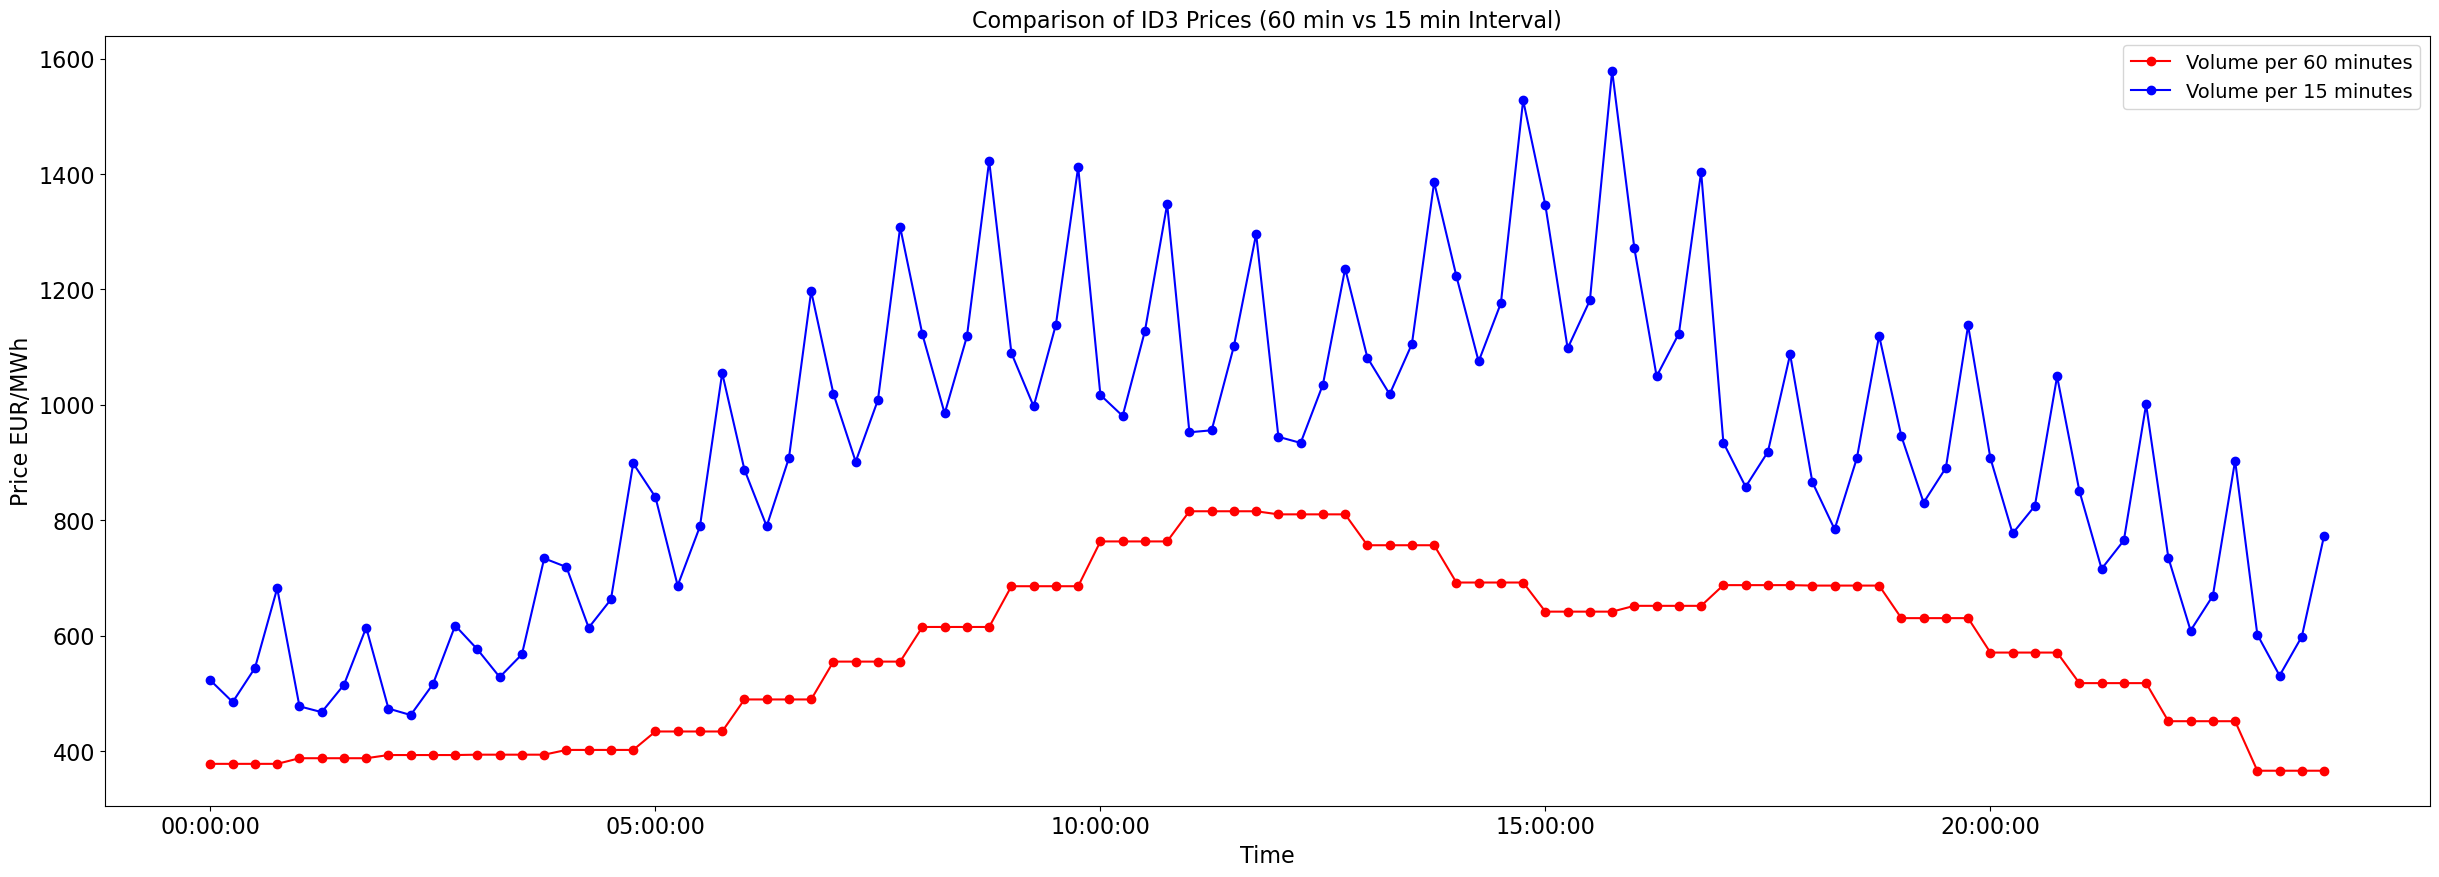

In [207]:
plt.figure(figsize=(30, 10))
plt.plot(volume_data_60_IDF["IndexVolume"], marker='o', linestyle='-', color='r', label='Volume per 60 minutes')
plt.plot(volume_data_15_IDF["IndexVolume"], marker='o', linestyle='-', color='b', label='Volume per 15 minutes')
plt.yticks(fontsize=16)


x_labels = volume_data_15_IDF["DeliveryStart"]
plt.xticks(ticks=range(0, len(x_labels), 20), labels=[x_labels[i] for i in range(0, len(x_labels), 20)], fontsize=16)



# Add a title
plt.title('Comparison of ID3 Prices (60 min vs 15 min Interval)', fontsize=16)



# Add x and y labels
plt.xlabel('Time', fontsize=16)
plt.ylabel('Price EUR/MWh', fontsize=16)

plt.legend(fontsize=14)

# Display the chart
plt.show()